In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.tokenize import word_tokenize

#For Stemming text
from nltk.stem import PorterStemmer        

import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

#To split data into train and test
from sklearn.model_selection import train_test_split

#For fitting model
from sklearn.linear_model import LogisticRegression

#For evaluation of model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data collection

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [3]:
print(os.listdir(path))

df = pd.read_csv(path+'/train.csv')

print(df.head())

['sample_submission.csv', 'train.csv', 'test.csv']
       textID                                               text  \
0  28ac06f416                        good luck with your auction   
1  92098cf9a7  Hmm..You can`t judge a book by looking at its ...   
2  7858ff28f2   Hello, yourself. Enjoy London. Watch out for ...   
3  b0c9c67f32         We can`t even call you from belgium  sucks   
4  7b36e9e7a5                                 not so good mood..   

                                       selected_text sentiment  
0                        good luck with your auction  positive  
1  Hmm..You can`t judge a book by looking at its ...   neutral  
2                                    They`re mental.  negative  
3                                            m  suck  negative  
4                                 not so good mood..  negative  


In [4]:
print(df.info())
print("Columns: " + df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24732 entries, 0 to 24731
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         24732 non-null  object
 1   text           24732 non-null  object
 2   selected_text  24732 non-null  object
 3   sentiment      24732 non-null  object
dtypes: object(4)
memory usage: 773.0+ KB
None
Index(['Columns: textID', 'Columns: text', 'Columns: selected_text',
       'Columns: sentiment'],
      dtype='object')
(24732, 4)


In [5]:
df.describe(include='all')

,textID,text,selected_text,sentiment
count,24732,24732,24732,24732
unique,24732,24732,20298,3
top,dfa774bd3d,Content content content .... gah! Story of my...,love,neutral
freq,1,1,174,10018


In [6]:
df['sentiment'].value_counts()

sentiment
neutral     10018
positive     7711
negative     7003
Name: count, dtype: int64

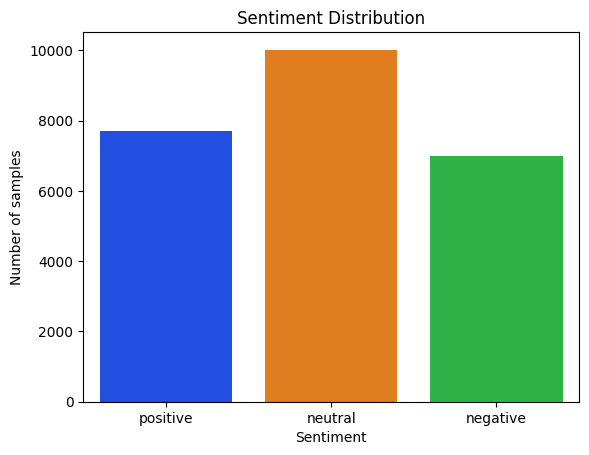

In [7]:
# Plot
sns.countplot(x='sentiment', data=df, palette='bright')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of samples')
plt.show()

# Preprocessing

## Text cleansing

In [8]:
'''
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# Carica modello spaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords personalizzate (manteniamo le negazioni)
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # Rimuove punteggiatura
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizzazione
    tokens = word_tokenize(text.lower())
    
    # Lemmatizzazione con spaCy (sul testo completamente lowercase)
    doc = nlp(" ".join(tokens).lower())
    lemmatized_tokens = [token.lemma_.lower() for token in doc]

    
    # Rimozione stopwords
    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]
    
    return final_tokens

df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))
'''

'\nimport nltk\nimport spacy\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nimport string\n\n\n# Carica modello spaCy\nnlp = spacy.load("en_core_web_sm")\n\n# Stopwords personalizzate (manteniamo le negazioni)\nstop_words = set(stopwords.words(\'english\'))\nnegations = {\'no\', \'not\', \'nor\'}\nstop_words = stop_words.difference(negations)\n\ndef preprocess_text(text):\n    # Rimuove punteggiatura\n    text = text.translate(str.maketrans(\'\', \'\', string.punctuation))\n    \n    # Tokenizzazione\n    tokens = word_tokenize(text.lower())\n    \n    # Lemmatizzazione con spaCy (sul testo completamente lowercase)\n    doc = nlp(" ".join(tokens).lower())\n    lemmatized_tokens = [token.lemma_.lower() for token in doc]\n\n    \n    # Rimozione stopwords\n    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]\n    \n    return final_tokens\n\ndf[\'removed_stop_words\'] = df[\'text\'].apply(lambda x: preprocess

In [9]:
!pip install spacy nltk num2words
!python -m nltk.downloader punkt stopwords
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=f67267f1c36b004571a9f75e9eafdaad3b304240ebda0a76ba18cdbe5fd6f654
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.9 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the packag

In [10]:
import re
import string
import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from num2words import num2words

# Downloads if needed
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom stopwords keeping negations
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 2. Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # 3. Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Convert numbers to words
    def replace_numbers(match):
        return num2words(match.group())
    text = re.sub(r'\b\d+\b', replace_numbers, text)
    
    # 6. Lowercase
    text = text.lower()
    
    # 7. Lemmatize and tokenize with spaCy
    doc = nlp(text)
    
    # 8. Remove stopwords and non-alpha tokens
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in stop_words and token.lemma_.isalpha()
    ]
    
    return tokens

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))

In [12]:
df.sample(10)

,textID,text,selected_text,sentiment,removed_stop_words
4302,9e0bc981a2,"I know it wasn`t going to be there, but I chec...","I know it wasn`t going to be there, but I chec...",neutral,"[know, not, go, check, eztv, office, torrent]"
4811,761342d7e9,My neighbour is fond of loud Nickelback.,fond,positive,"[neighbour, fond, loud, nickelback]"
2864,62db06ec81,"actually, i really do. mostly when i forget t...","actually, i really do. mostly when i forget to...",neutral,"[actually, really, mostly, forget, take, makeu..."
19230,cc13f743da,"just got out of prom, it was fun off too afte...",it was fun off too,positive,"[get, prom, fun, prom, text]"
14597,b85186a6cb,didn`t know you were on twitter! Coming to th...,didn`t know you were on twitter! Coming to the...,neutral,"[not, know, twitter, come, show, tomorrow, lor..."
6893,2565e03056,Went shopping a lil... I deserve it... And now...,deserve,positive,"[go, shop, lil, deserve, night, town, big, cit..."
9418,e3fd4897a0,http://twitpic.com/67tcr - Ouch!! Burnt my arm...,Ouch!! Burnt my arm,negative,"[ouch, burn, arm, grill]"
21693,c3be30cde6,great show today,great show today,positive,"[great, show, today]"
14678,005c6317fa,Hi...!!! Who is Mary Poppins???,Hi...!!! Who is Mary Poppins???,neutral,"[hi, mary, poppin]"
17318,4caf26e513,yess you?,yess you?,neutral,[yess]


In [13]:
df[df['removed_stop_words'].apply(lambda tokens: 'mother' in tokens)]

,textID,text,selected_text,sentiment,removed_stop_words
19,fe54c45844,can`t believe I just drove all the way back to...,HAPPY,positive,"[not, believe, drive, way, back, schoolwhateve..."
52,f22dd850f7,happy mother`s day to all the moms out there. ...,happy mother`s day,positive,"[happy, mother, day, mom, hope, never, join, c..."
63,4e53704d24,in about 30 minutes Happy Mothers Day to alll ...,Happy,positive,"[thirty, minute, happy, mother, day, alll, ama..."
93,ee91ba580f,Happy Mother`s Day ~ Did you watch SNL? If n...,Happy Mother`s Day,positive,"[happy, mother, day, watch, snl, not, u, miss,..."
110,8976579aa1,"Mom, where ever you are; Happy Mothers day",Happy,positive,"[mom, ever, happy, mother, day]"
...,...,...,...,...,...
24548,dbb2960dc7,Searching my home for a few things to cook the...,Searching my home for a few things to cook the...,neutral,"[search, home, thing, cook, dinner, evening, m..."
24588,ba0f683c89,"Wishing you a very Happy Mother`s Day, Carina...",Happy,positive,"[wish, happy, mother, day, carina, hugsjoy]"
24626,563148673a,happy mothers day,happy mo,positive,"[happy, mother, day]"
24691,a1c8f1e077,Happy Mothers Day! i hope tom got you somethi...,Happy Mothers Day!,positive,"[happy, mother, day, hope, tom, get, something..."


In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the unique sentiment classes you want to generate clouds for
sentiments = ['neutral', 'positive', 'negative']

# Loop through each class
for sentiment in sentiments:
    # Filter the DataFrame by sentiment class
    subset = df[df['sentiment'] == sentiment]

    # Flatten the token lists into a single string
    all_words = ' '.join([' '.join(tokens) for tokens in subset['removed_stop_words']])

    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    # Display the word cloud (optional)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} WordCloud', fontsize=16)

    # Save the figure locally
    filename = f"{sentiment}_wordcloud.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close the plot to avoid displaying all of them in notebook

    print(f"Saved: {filename}")

Saved: neutral_wordcloud.png
Saved: positive_wordcloud.png
Saved: negative_wordcloud.png


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


🔢 Step 1: Encoding delle etichette
📦 Step 2: Conversione in Hugging Face Dataset e split 70/15/15
✏️ Step 3: Tokenizzazione


Map:   0%|          | 0/17311 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3711 [00:00<?, ? examples/s]

Map:   0%|          | 0/3710 [00:00<?, ? examples/s]

🧠 Step 4: Caricamento del modello
✅ Device in uso: cuda
📊 Step 5: Definizione delle metriche
⚙️ Step 6: Definizione parametri di training
🚀 Step 7: Inizializzazione Trainer


/tmp/ipykernel_35/3082482284.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🏋️ Step 8: Inizio fine-tuning...


Step,Training Loss
10,0.645000
20,0.609300
30,0.599600
40,0.484100
50,0.670600
60,0.539900
70,0.517500
80,0.590100
90,0.585400
100,0.554900


🧪 Step 9: Valutazione sul test set


📊 Test set performance:
{'eval_loss': 0.5729836821556091, 'eval_accuracy': 0.8110512129380054, 'eval_f1': 0.8110333174510875, 'eval_precision': 0.8110645884343438, 'eval_recall': 0.8110512129380054, 'eval_runtime': 4.6772, 'eval_samples_per_second': 793.207, 'eval_steps_per_second': 24.801, 'epoch': 3.0}
📉 Step 9b: Confusion Matrix
📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.82      0.81       989
     neutral       0.79      0.78      0.79      1554
    positive       0.85      0.84      0.85      1167

    accuracy                           0.81      3710
   macro avg       0.81      0.81      0.81      3710
weighted avg       0.81      0.81      0.81      3710



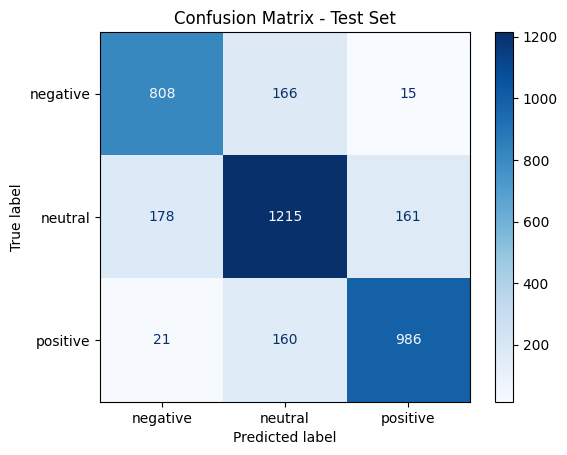

💾 Step 10: Salvataggio del modello fine-tuned
✅ Modello salvato in ./sentiment-roberta-finetuned


In [22]:
!pip install -q transformers datasets

import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("🔢 Step 1: Encoding delle etichette")
label_names = ["negative", "neutral", "positive"]
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])

print("📦 Step 2: Conversione in Hugging Face Dataset e split 70/15/15")
dataset = Dataset.from_pandas(df[["text", "label"]])
train_val_test = dataset.train_test_split(test_size=0.15, seed=42)
train_val = train_val_test["train"].train_test_split(test_size=0.1765, seed=42)
dataset_dict = DatasetDict({
    "train": train_val["train"],
    "validation": train_val["test"],
    "test": train_val_test["test"]
})

print("✏️ Step 3: Tokenizzazione")
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_datasets = dataset_dict.map(tokenize, batched=True)

print("🧠 Step 4: Caricamento del modello")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device in uso: {device}")
model.to(device)

print("📊 Step 5: Definizione delle metriche")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

print("⚙️ Step 6: Definizione parametri di training")
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    logging_dir="./logs",
    logging_strategy="steps",           # <── aggiunto
    logging_steps=10,                   # <── ogni 10 batch
    #evaluation_strategy="epoch",        # <── valuta a ogni epoca
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",                   # <── evita di usare WandB o TensorBoard se non servono
    disable_tqdm=False                  # <── abilita la barra di avanzamento se disabilitata
)

print("🚀 Step 7: Inizializzazione Trainer")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("🏋️ Step 8: Inizio fine-tuning...")
trainer.train()

print("🧪 Step 9: Valutazione sul test set")
metrics = trainer.evaluate(tokenized_datasets["test"])
print("📊 Test set performance:")
print(metrics)
print("📉 Step 9b: Confusion Matrix")

# Ottieni le predizioni dal test set
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Stampa il classification report
print("📋 Classification Report:")
print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))

# Visualizza la confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.grid(False)
plt.show()
print("💾 Step 10: Salvataggio del modello fine-tuned")
trainer.save_model("./sentiment-roberta-finetuned")
tokenizer.save_pretrained("./sentiment-roberta-finetuned")
print("✅ Modello salvato in ./sentiment-roberta-finetuned")


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer

# Ricarica il Trainer (se non l'hai già)
trainer = Trainer(model=model, tokenizer=tokenizer)

# Esegui predizione sul test set
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Confusion matrix
print("📉 Confusion Matrix:")
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.grid(False)
plt.show()


/tmp/ipykernel_35/3999661401.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

## Jaccard Score

In [ ]:
def jaccard_score(predictions, ground_truth):
    intersection = np.sum(np.logical_and(predictions, ground_truth))
    union = np.sum(np.logical_or(predictions, ground_truth))
    return intersection / union if union != 0 else 0

# Calcola Jaccard Score
jaccard = jaccard_score(preds, labels)